In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Define kaggle json path
# Sesuaikan dengan path anda
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/My Drive/MachineL/Modul3"

In [ ]:
# Ubah lokasi direktori kerja
# Sesuaikan dengan path anda
%cd /content/drive/My Drive/MachineL/Modul3

/content/drive/My Drive/MachineL/Modul3


In [ ]:
!ls  

kaggle.json


In [ ]:
!kaggle datasets download -d drgfreeman/rockpaperscissors

 95% 290M/306M [00:01<00:00, 168MB/s]
100% 306M/306M [00:01<00:00, 167MB/s]


In [ ]:
!ls

kaggle.json  rockpaperscissors.zip


In [ ]:

!unzip \*.zip &> /dev/null && rm *.zip

In [ ]:
!ls

kaggle.json  paper  README_rpc-cv-images.txt  rock  rps-cv-images  scissors


In [ ]:
!mkdir rockpaperscissors

In [ ]:
!ls

kaggle.json  README_rpc-cv-images.txt  rockpaperscissors  scissors
paper	     rock		       rps-cv-images


In [ ]:
!mkdir rockpaperscissors/datasets

In [ ]:
!ls

kaggle.json  README_rpc-cv-images.txt  rockpaperscissors  scissors
paper	     rock		       rps-cv-images


In [ ]:
!mv "/content/drive/My Drive/MachineL/Modul3/rock" "/content/drive/My Drive/MachineL/Modul3/rockpaperscissors/datasets"
!mv "/content/drive/My Drive/MachineL/Modul3/paper" "/content/drive/My Drive/MachineL/Modul3/rockpaperscissors/datasets"
!mv "/content/drive/My Drive/MachineL/Modul3/scissors" "/content/drive/My Drive/MachineL/Modul3/rockpaperscissors/datasets"

In [ ]:
!ls rockpaperscissors/datasets

paper  rock  scissors


In [ ]:
%cd /content/drive/My Drive/MachineL/Modul3/rockpaperscissors/datasets

/content/drive/My Drive/MachineL/Modul3/rockpaperscissors/datasets


In [ ]:
!ls

paper  rock  scissors


In [ ]:
base_dir = "/content/drive/My Drive/MachineL/Modul3/rockpaperscissors"
data_dir = "/content/drive/My Drive/MachineL/Modul3/rockpaperscissors/datasets"

In [ ]:
pip install split-folders

In [ ]:
import splitfolders
splitfolders.ratio(data_dir, output=base_dir, seed=1337, ratio=(.7, .15, .15))

Copying files: 2188 files [00:28, 77.28 files/s]


In [ ]:
ls rockpaperscissors

datasets/  test/  train/  val/


## **Preprocessing**

In [ ]:
import os

train_path = os.path.join(base_dir, 'train')
test_path  = os.path.join(base_dir, 'test')
val_path   = os.path.join(base_dir, 'val')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle

batch_size = 32
augmen_gen = ImageDataGenerator(rescale=1. / 255,
                                rotation_range=40,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True,
                                fill_mode='nearest')

train_gen = augmen_gen.flow_from_directory(
    train_path,
    class_mode = 'categorical',
    shuffle=True,
    target_size = (224,224),
    batch_size=batch_size,
    color_mode ='rgb'
)

val_gen = augmen_gen.flow_from_directory(
    val_path,
    class_mode = 'categorical',
    shuffle=True,
    target_size = (224,224),
    batch_size= batch_size,
    color_mode ='rgb'
)

test_gen = augmen_gen.flow_from_directory(
    test_path,
    class_mode = 'categorical',
    shuffle=False,
    target_size = (224,224),
    batch_size=batch_size,
    color_mode ='rgb',
)

Found 1531 images belonging to 3 classes.
Found 326 images belonging to 3 classes.
Found 331 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, Conv2D, MaxPool2D, Flatten, BatchNormalization, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
import time

In [ ]:
#Feature Selection
model = Sequential()

model.add(InputLayer(input_shape=[224,224,3]))
model.add(Conv2D(filters=32, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=64, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Conv2D(filters=128, kernel_size=3, strides=1, padding='same', activation='relu'))
model.add(MaxPool2D(pool_size=2, padding='same'))
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Flatten())

#Fully Connected Layer
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(3, activation='softmax'))


In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 56, 56, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 28, 28, 128)       0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28, 128)       0

In [ ]:
best_model_path = 'best_model.h5'
checkpoint_callback = ModelCheckpoint(best_model_path,
                                      monitor='val_accuracy',
                                      save_best_only=True,
                                      verbose=1)
reduce_callback = ReduceLROnPlateau(monitor='val_accuracy', patience=3, factor=0.5, min_lr=0.000003, verbose=1)
callbacks_list = [checkpoint_callback, reduce_callback]

In [ ]:
learning_rate = 0.00001

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=learning_rate),
              metrics='accuracy')

In [ ]:
start = time.time()
H = model.fit_generator(train_gen, epochs=25,validation_data=val_gen, validation_steps = 4, verbose=1, callbacks=[callbacks_list])

End = time.time()
print ("training time: ", End-start,"s")  # the time would be round to 3 decimal in seconds

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/25
48/48 [==============================] - ETA: 0s - loss: 1.1111 - accuracy: 0.4637
Epoch 00001: val_accuracy improved from -inf to 0.26562, saving model to best_model.h5
48/48 [==============================] - 26s 541ms/step - loss: 1.1111 - accuracy: 0.4637 - val_loss: 1.1033 - val_accuracy: 0.2656
Epoch 2/25
48/48 [==============================] - ETA: 0s - loss: 0.9723 - accuracy: 0.5474
Epoch 00002: val_accuracy improved from 0.26562 to 0.57812, saving model to best_model.h5
48/48 [==============================] - 26s 546ms/step - loss: 0.9723 - accuracy: 0.5474 - val_loss: 1.0602 - val_accuracy: 0.5781
Epoch 3/25
48/48 [==============================] - ETA: 0s - loss: 0.8626 - accuracy: 0.6035
Epoch 00003: val_accuracy improved from 0.57812 to 0.71875, saving model to best_model.h5
48/48 [==============================] - 26s 540ms/step - loss: 0.8626 - accuracy: 0.6035 - val_loss: 1.0390 - 

# **Evaluate**

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
from google.colab import files

In [ ]:
model.load_weights(best_model_path)

ypred = model.predict(test_gen)
prediction = np.argmax(ypred, axis=1)
print(classification_report(test_gen.classes, prediction))

              precision    recall  f1-score   support

           0       0.91      0.89      0.90       108
           1       0.90      0.94      0.92       110
           2       0.93      0.91      0.92       113

    accuracy                           0.91       331
   macro avg       0.91      0.91      0.91       331
weighted avg       0.91      0.91      0.91       331



Confusion matrix, without normalization
[[ 96   5   7]
 [  6 103   1]
 [  4   6 103]]


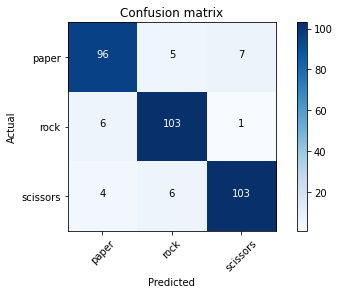

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Actual')
    plt.xlabel('Predicted')

cnf_matrix=confusion_matrix(test_gen.classes,prediction)
plot_confusion_matrix(cnf_matrix, classes=test_gen.class_indices)

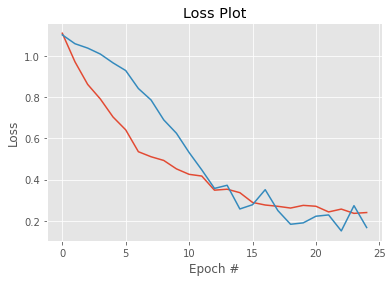

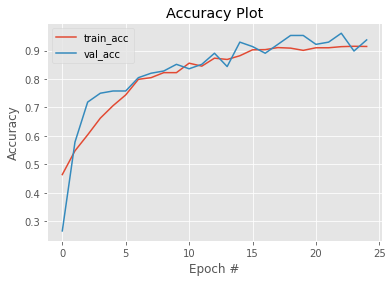

In [ ]:
plt.style.use("ggplot")

plt.plot(np.arange(0, 25), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 25), H.history["val_loss"], label="val_loss")
plt.title("Loss Plot")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.show()

plt.plot(np.arange(0, 25), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 25), H.history["val_accuracy"], label="val_acc")
plt.title("Accuracy Plot")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

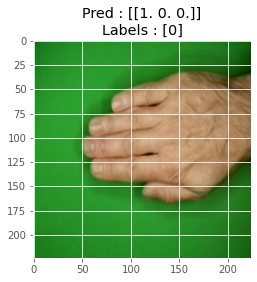

In [ ]:
import PIL

def predictModel(image_path):
    img = PIL.Image.open(image_path)
    img_resized = img.resize((224, 224), PIL.Image.LANCZOS)

    plt.imshow(img_resized)

    img_array = np.expand_dims(np.array(img_resized), axis=0)

    pred_coba = model.predict_classes(img_array)
    a = model.predict(img_array)

    labels = np.argmax(a, axis=1)

    plt.title(f"Pred : {a}\nLabels : {labels}")

predictModel("/content/drive/My Drive/MachineL/Modul3/rockpaperscissors/test/paper/6ycslJxTsTjZc5H2.png")